In [1]:
import fastf1
from fastf1 import plotting
fastf1.Cache.enable_cache('./cache')  # Cache to store downloaded data

# Load race session: Example - 2023 Bahrain Grand Prix
session = fastf1.get_session(2023, 'Bahrain', 'R')
session.load()


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


In [2]:
laps = session.laps

# Optional: Filter to only include drivers who completed the race
laps = laps.loc[laps['LapTime'].notnull()]


In [3]:
# Select relevant columns
tire_data = laps[["Driver", "LapNumber", "Compound", "Stint", "LapTime", "TrackStatus", "Team"]]

# Convert LapTime to seconds
tire_data["LapTimeSeconds"] = tire_data["LapTime"].dt.total_seconds()


C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\1477276930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tire_data["LapTimeSeconds"] = tire_data["LapTime"].dt.total_seconds()


In [4]:
# Group by driver and stint
tire_data['StintLap'] = tire_data.groupby(['Driver', 'Stint']).cumcount() + 1

# Normalize lap times within each stint to measure degradation
tire_data['DeltaFromFirstLap'] = tire_data.groupby(['Driver', 'Stint'])['LapTimeSeconds'].transform(lambda x: x - x.iloc[0])


C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\4227737760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tire_data['StintLap'] = tire_data.groupby(['Driver', 'Stint']).cumcount() + 1
C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\4227737760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tire_data['DeltaFromFirstLap'] = tire_data.groupby(['Driver', 'Stint'])['LapTimeSeconds'].transform(lambda x: x - x.iloc[0])


In [5]:
circuits = ['Bahrain', 'Jeddah', 'Australia', 'Monaco']
years = [2022, 2023]

all_data = []

for year in years:
    for circuit in circuits:
        try:
            session = fastf1.get_session(year, circuit, 'R')
            session.load()
            laps = session.laps
            laps = laps[laps['LapTime'].notnull()]
            laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
            laps['Circuit'] = circuit
            laps['Year'] = year
            all_data.append(laps)
        except Exception as e:
            print(f"Error loading {circuit} {year}: {e}")


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', 

Libraries

In [6]:
import pandas as pd
import numpy as np

Data Loading and Processing 


In [7]:
df = pd.read_csv('f1_tire_degradation_data.csv')

In [8]:
print(df.head())

                     Time Driver  DriverNumber                 LapTime  \
0  0 days 01:04:15.340000    VER             1  0 days 00:01:40.236000   
1  0 days 01:05:53.220000    VER             1  0 days 00:01:37.880000   
2  0 days 01:07:31.577000    VER             1  0 days 00:01:38.357000   
3  0 days 01:09:10.143000    VER             1  0 days 00:01:38.566000   
4  0 days 01:10:49.020000    VER             1  0 days 00:01:38.877000   

   LapNumber  Stint PitOutTime PitInTime             Sector1Time  \
0        1.0    1.0        NaN       NaN                     NaN   
1        2.0    1.0        NaN       NaN  0 days 00:00:31.285000   
2        3.0    1.0        NaN       NaN  0 days 00:00:31.499000   
3        4.0    1.0        NaN       NaN  0 days 00:00:31.342000   
4        5.0    1.0        NaN       NaN  0 days 00:00:31.498000   

              Sector2Time  ...             LapStartDate TrackStatus Position  \
0  0 days 00:00:42.325000  ...  2022-03-20 15:03:34.889           

In [9]:
# Remove laps more than 3 standard deviations from mean
df = df[df.groupby(['Compound'])['LapTimeSeconds'].transform(
    lambda x: np.abs(x - x.mean()) < 3 * x.std()
)]

In [10]:
df['StintLap'] = df.groupby(['Driver', 'Year', 'Circuit', 'Stint']).cumcount() + 1

In [11]:
df['DeltaFromFirstLap'] = df.groupby(['Driver', 'Year', 'Circuit', 'Stint'])['LapTimeSeconds'].transform(
    lambda x: x - x.iloc[0]
)


In [12]:
df.to_csv('f1_cleaned_tire_data.csv', index=False)
print("✅ Cleaned data saved.")

✅ Cleaned data saved.


In [13]:
# Load cleaned data if not already in memory
import pandas as pd

df = pd.read_csv('f1_cleaned_tire_data.csv')

# Group by Circuit, Compound, and StintLap
grouped = df.groupby(['Circuit', 'Compound', 'StintLap'])['DeltaFromFirstLap'].mean().reset_index()

# Rename the result for clarity
grouped.rename(columns={'DeltaFromFirstLap': 'AvgDeltaFromFirstLap'}, inplace=True)

# Preview the grouped data
print(grouped.head())


     Circuit Compound  StintLap  AvgDeltaFromFirstLap
0  Abu Dhabi     HARD         1              0.000000
1  Abu Dhabi     HARD         2            -19.698043
2  Abu Dhabi     HARD         3            -19.832391
3  Abu Dhabi     HARD         4            -19.767217
4  Abu Dhabi     HARD         5            -19.722826


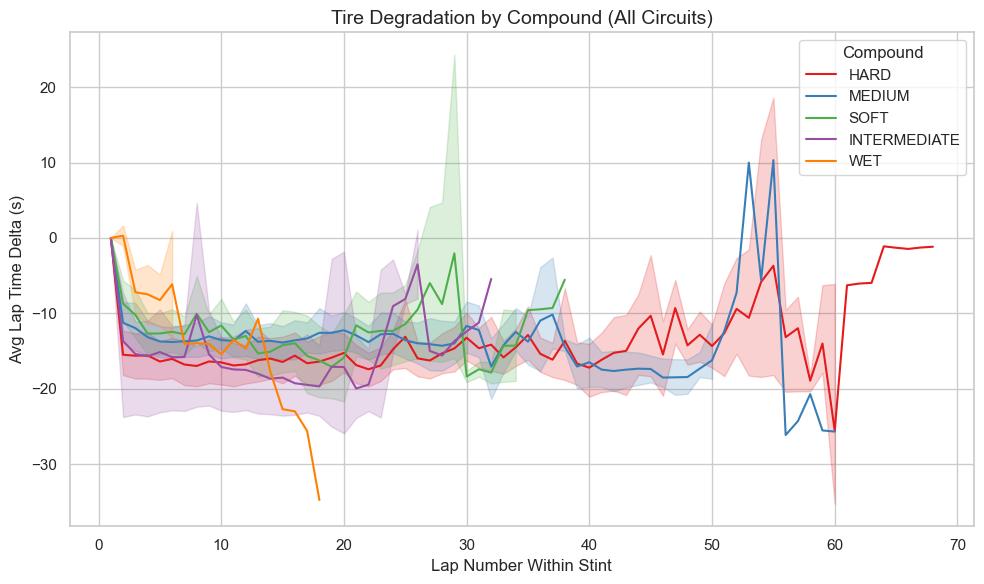

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='StintLap', y='AvgDeltaFromFirstLap', hue='Compound', palette='Set1')

plt.title('Tire Degradation by Compound (All Circuits)', fontsize=14)
plt.xlabel('Lap Number Within Stint')
plt.ylabel('Avg Lap Time Delta (s)')
plt.legend(title='Compound')
plt.tight_layout()
plt.show()


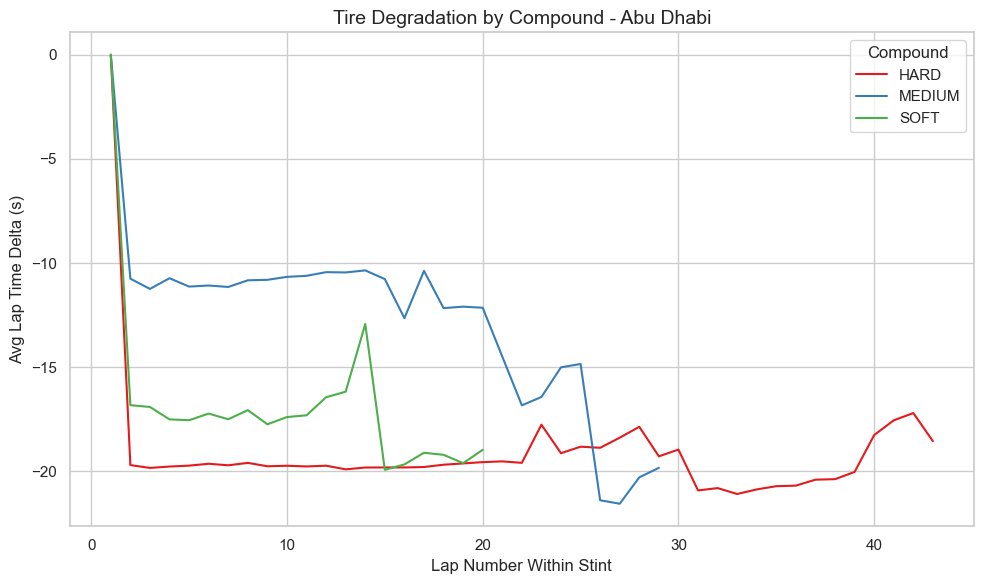

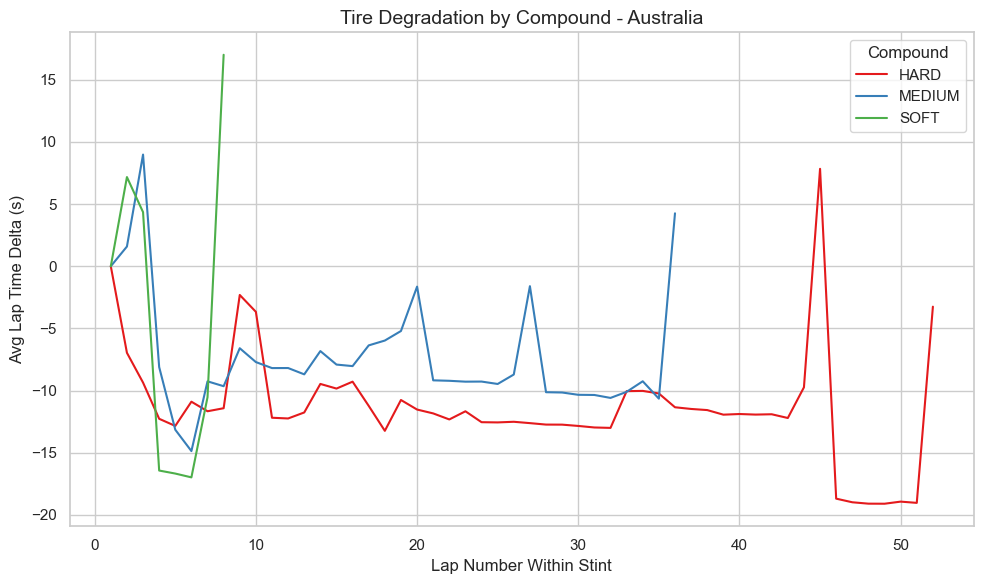

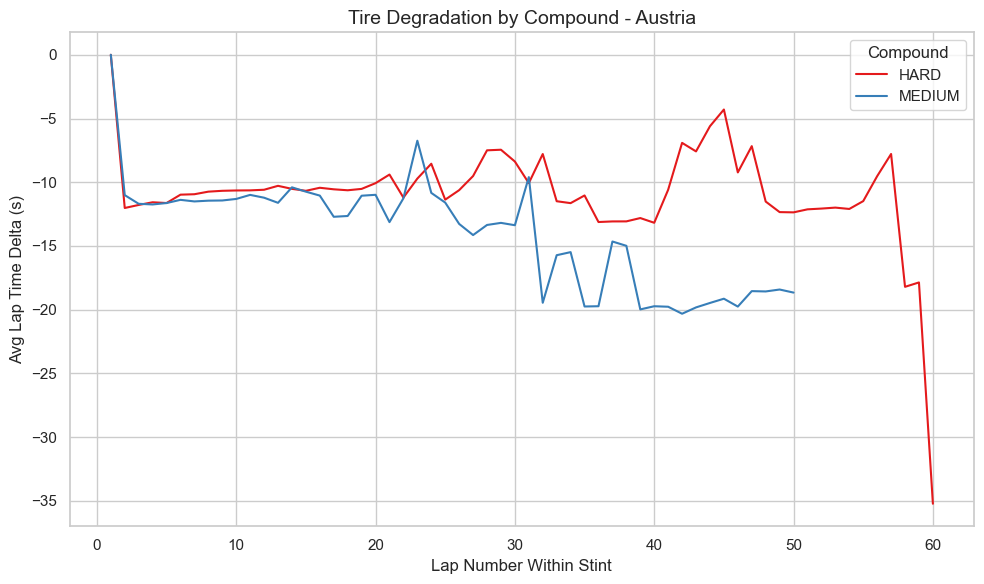

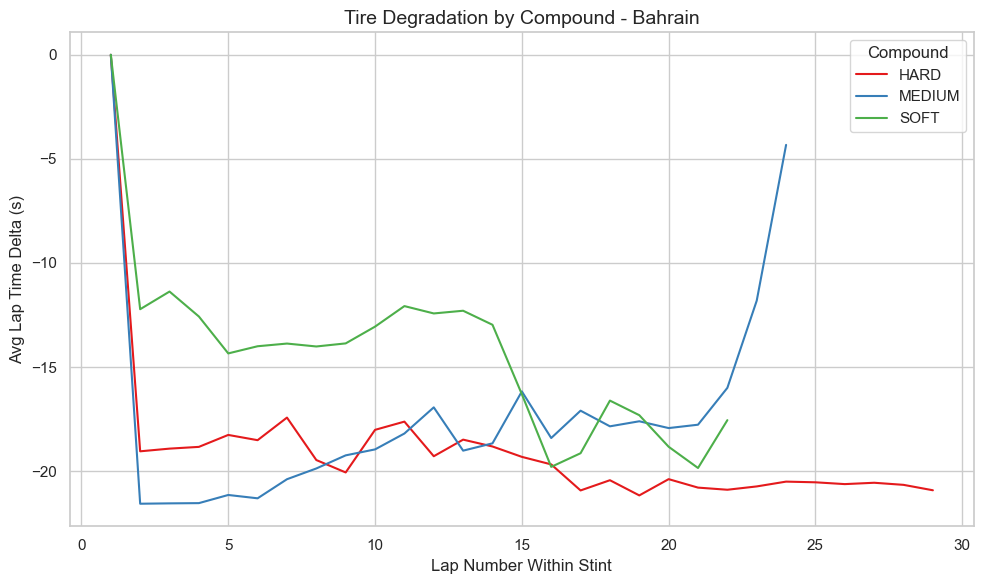

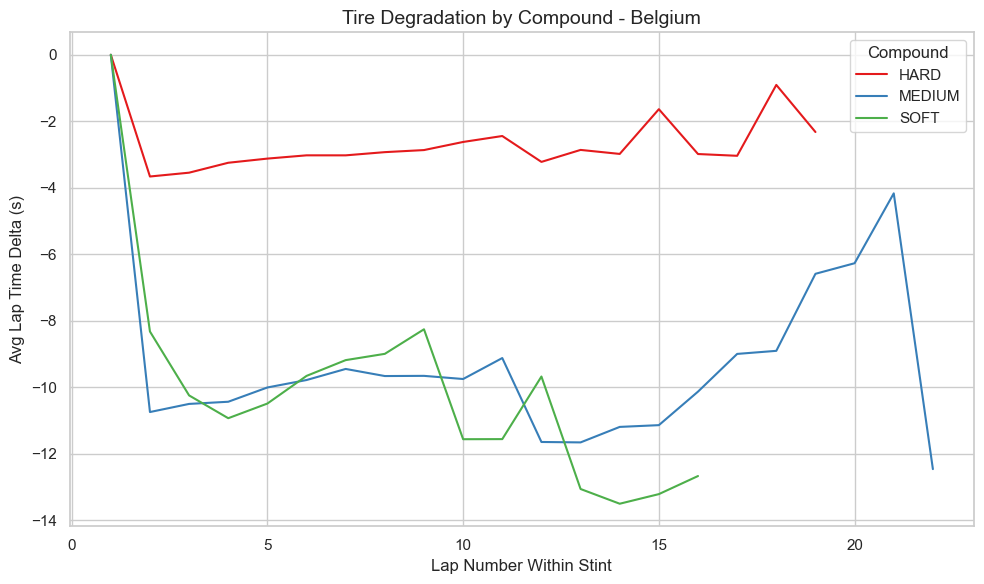

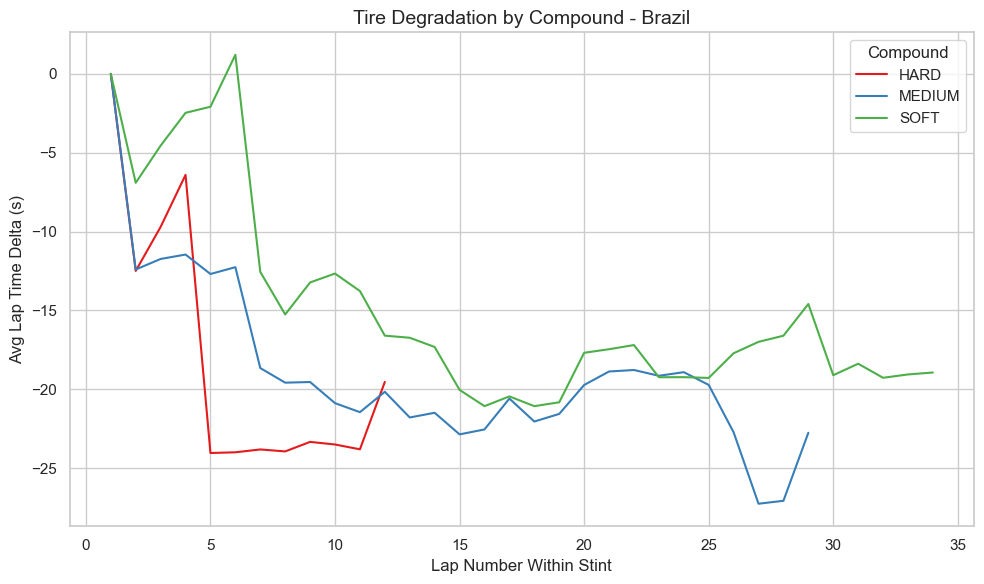

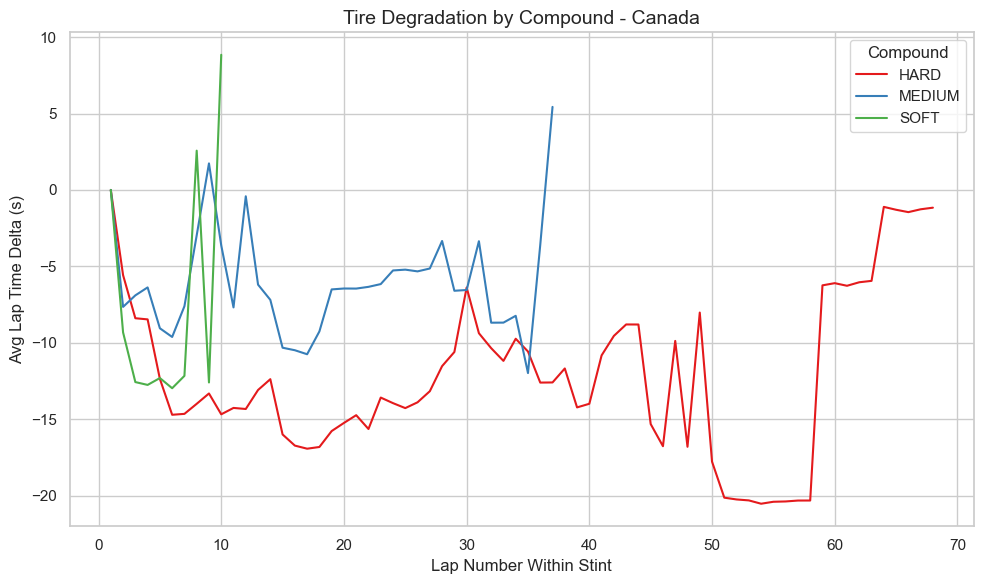

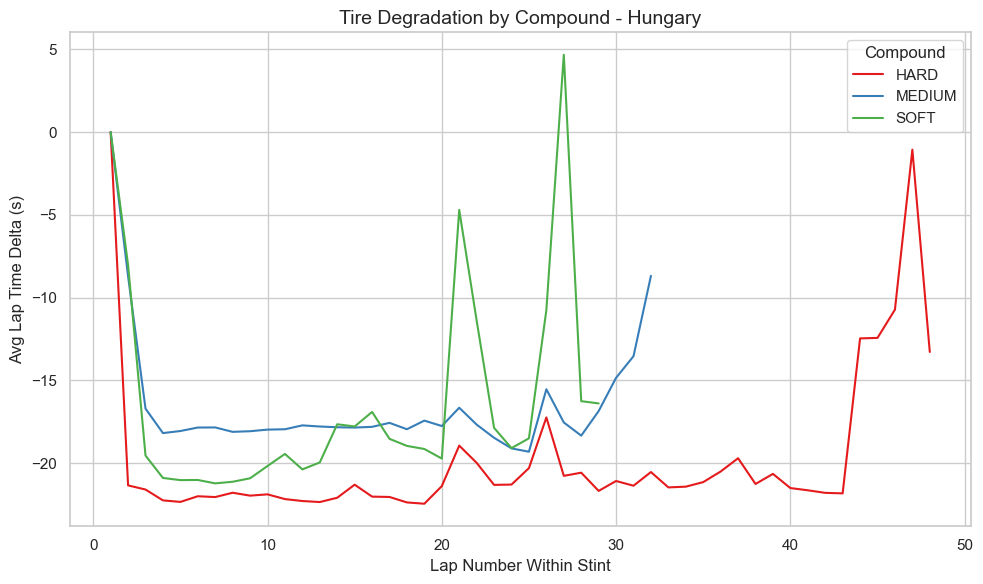

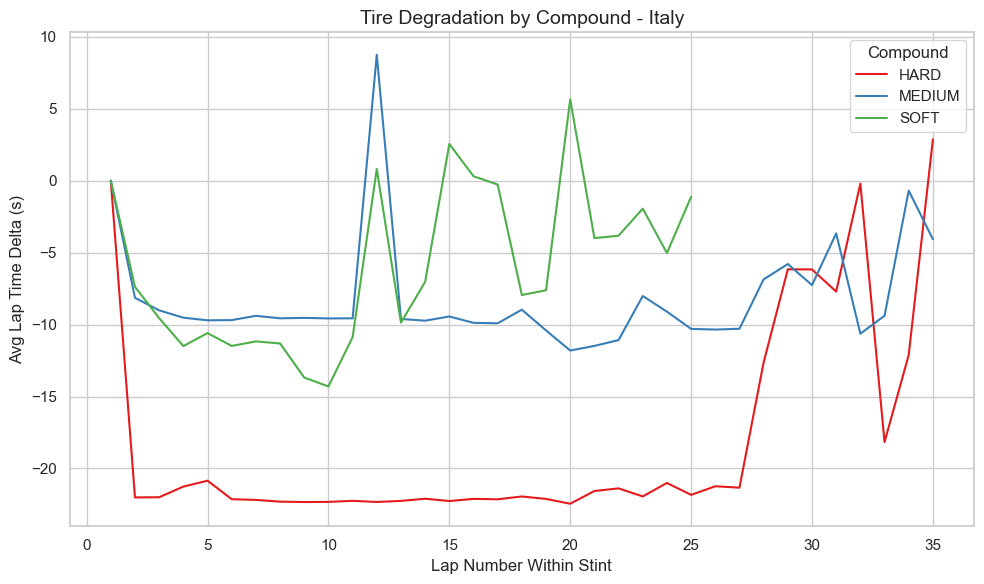

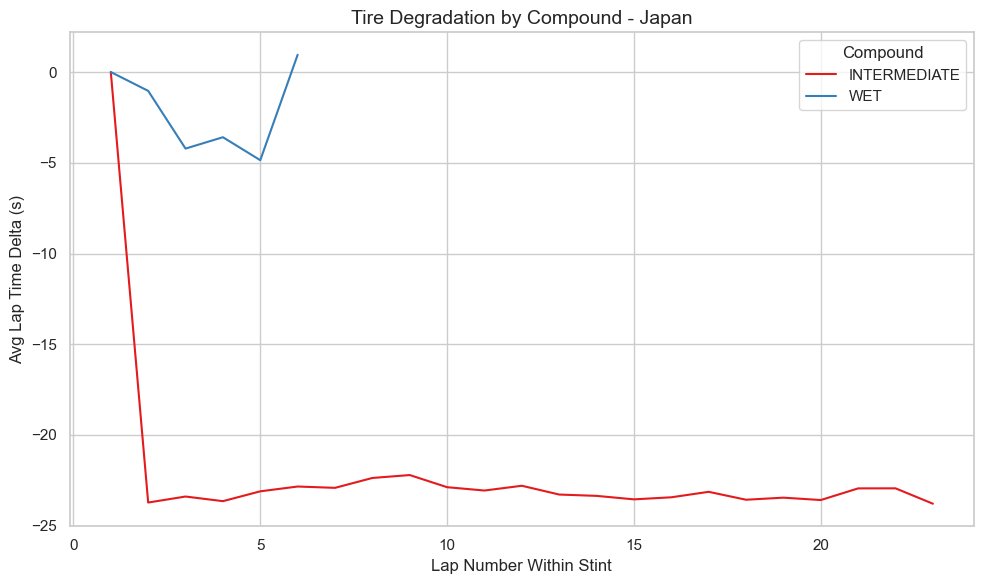

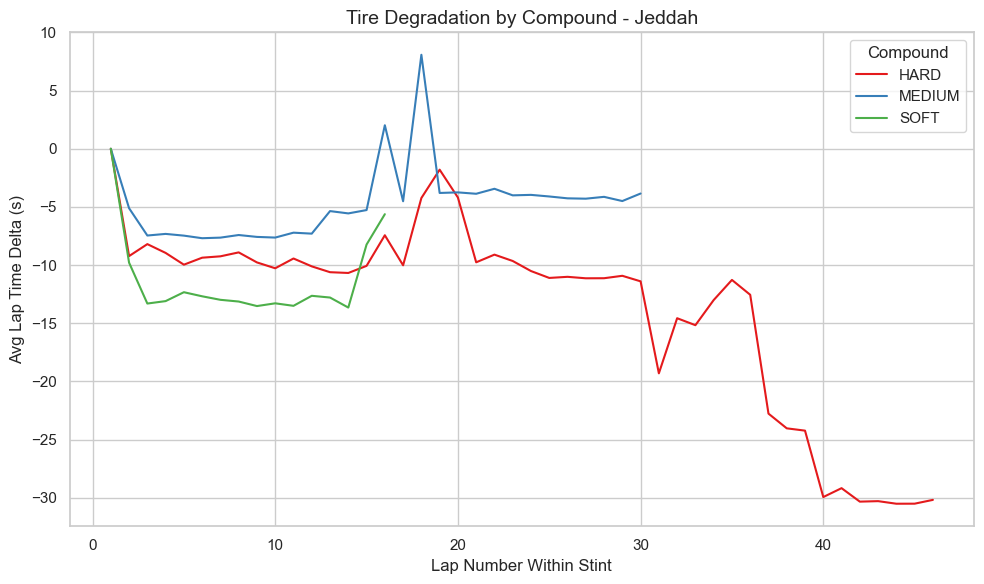

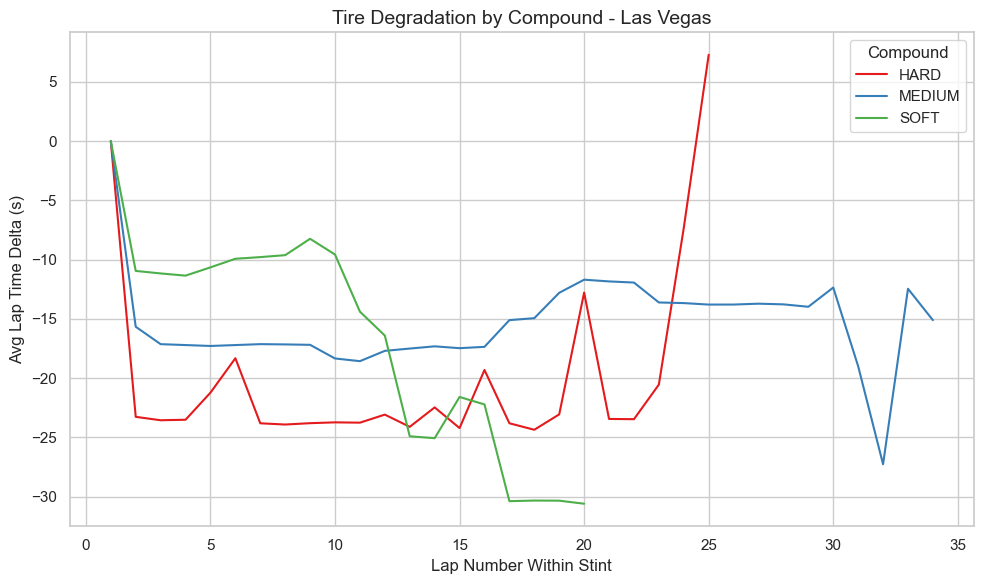

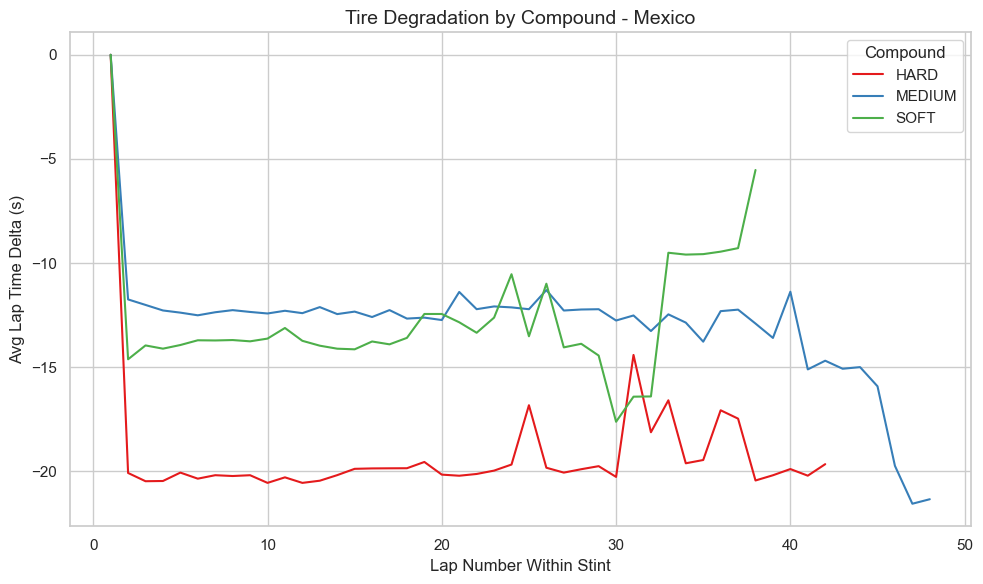

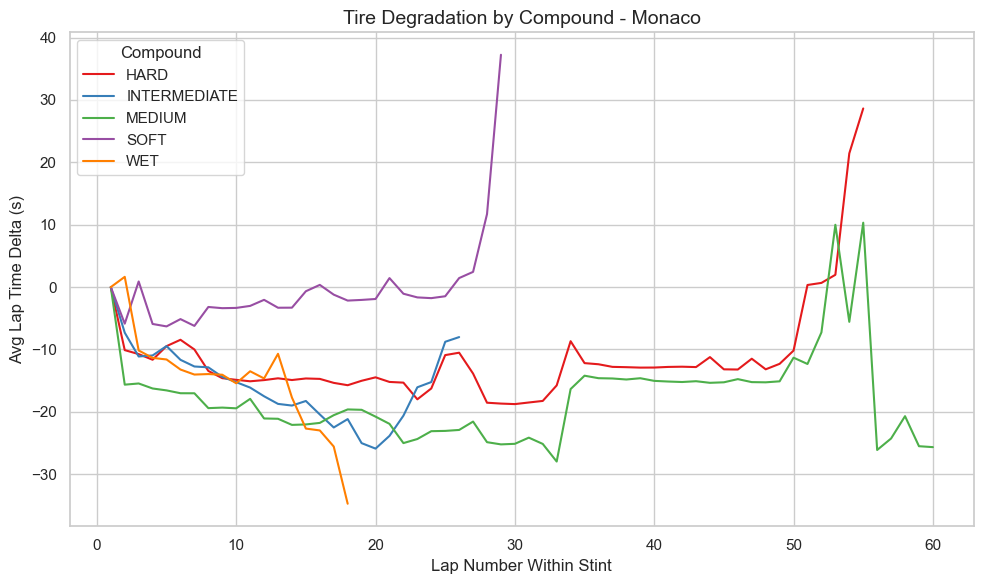

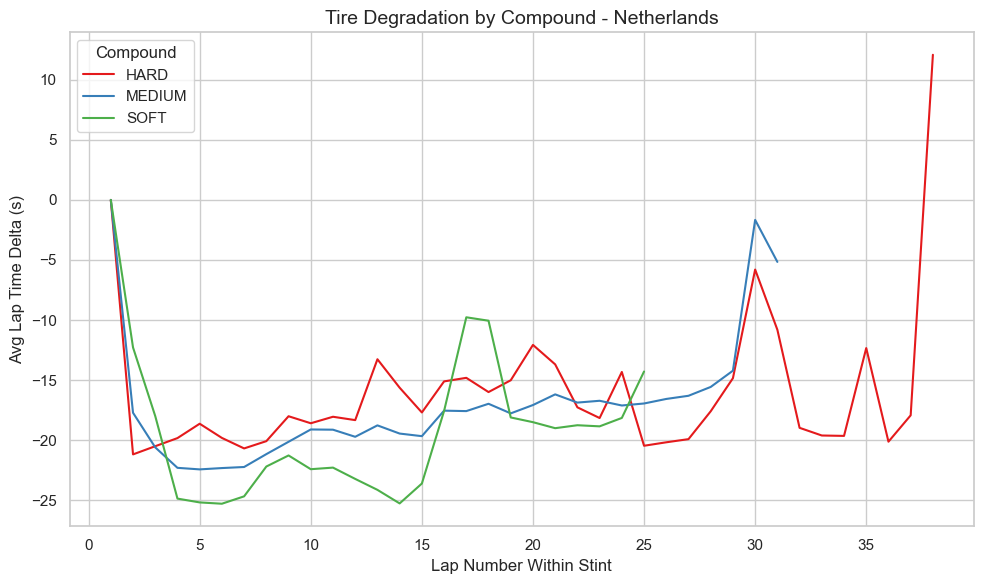

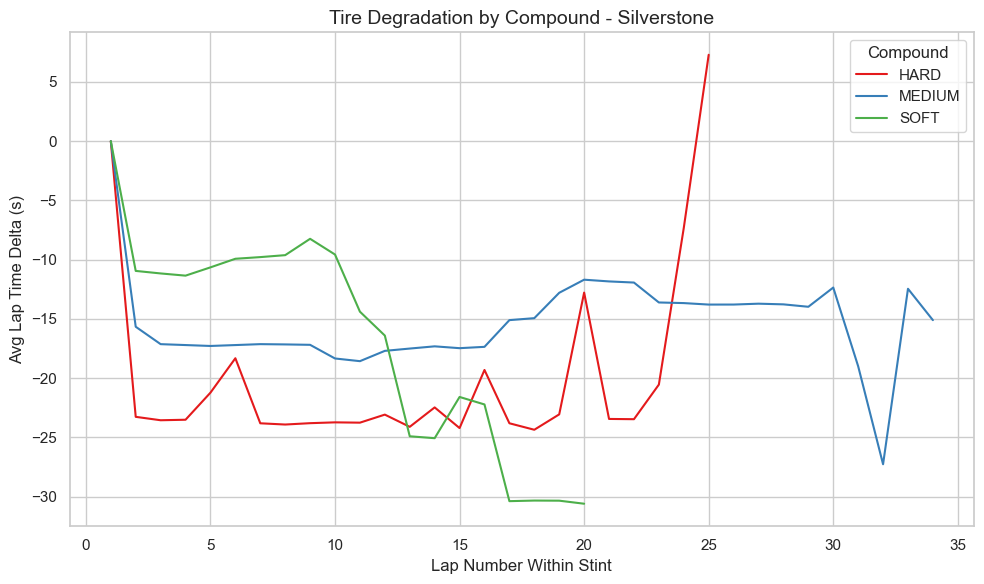

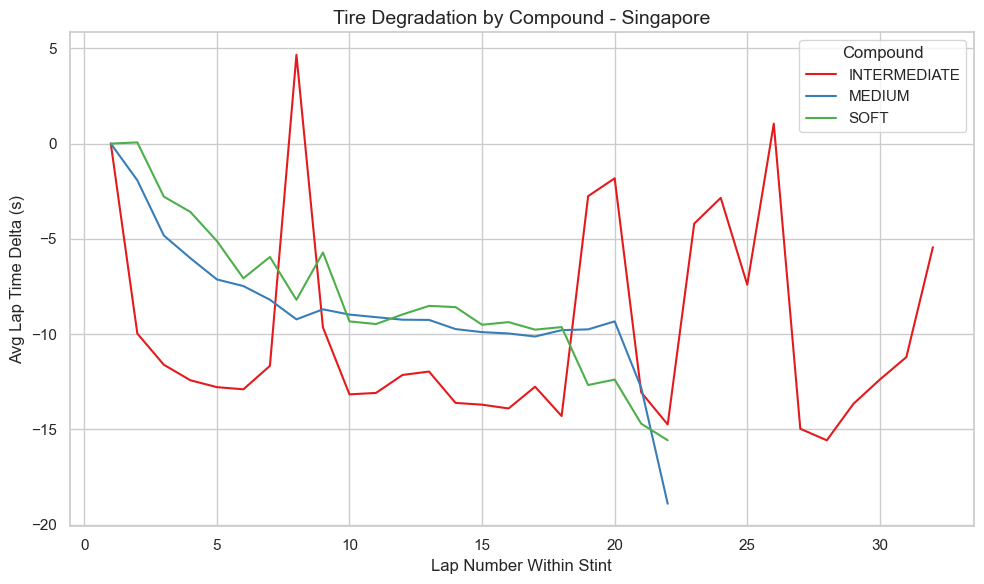

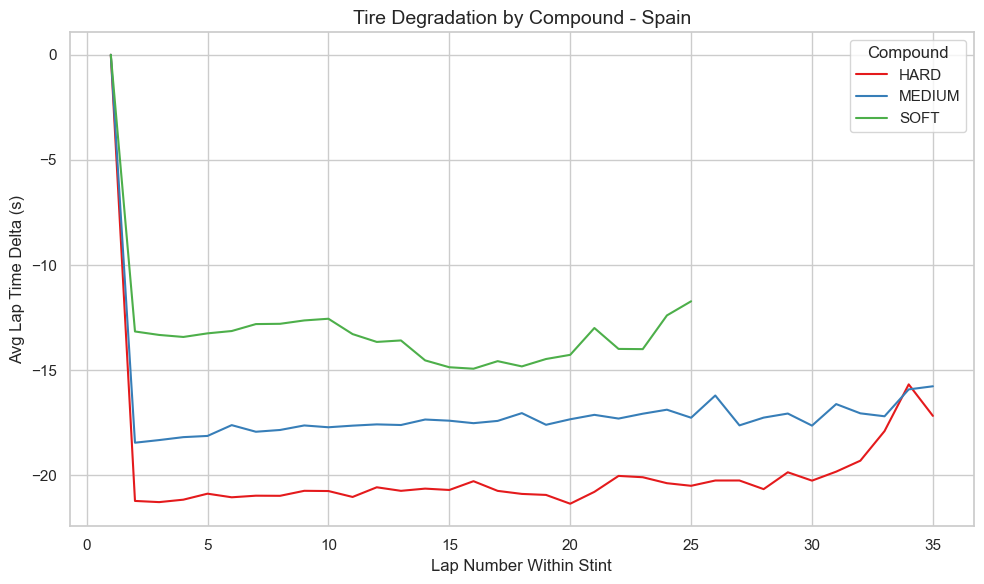

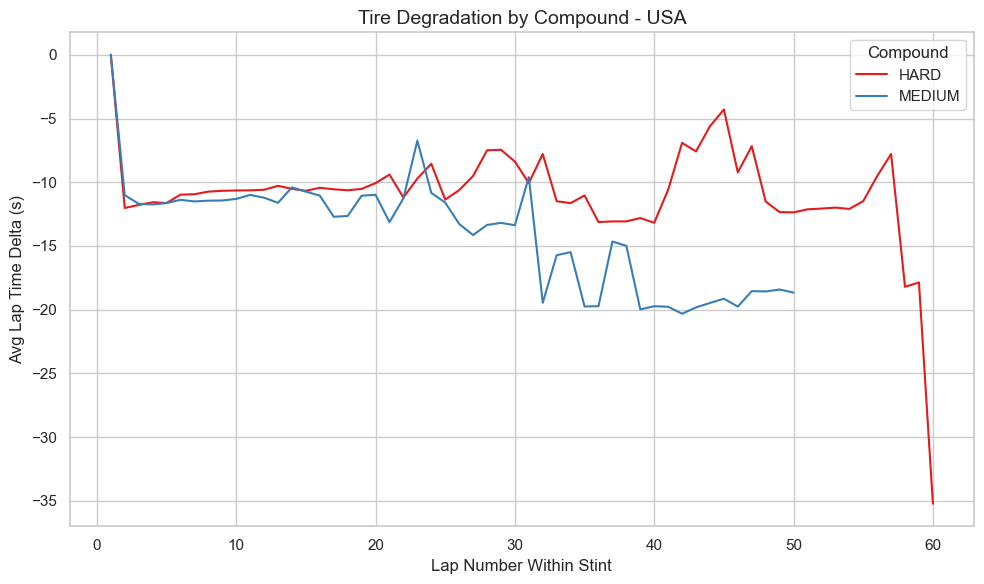

In [15]:
# Plot line graphs for each circuit to visualize tire degradation by compound

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique circuits
circuits = grouped['Circuit'].unique()

# Set style
sns.set(style="whitegrid")

for circuit in circuits:
    plt.figure(figsize=(10, 6))
    circuit_data = grouped[grouped['Circuit'] == circuit]
    sns.lineplot(
        data=circuit_data,
        x='StintLap',
        y='AvgDeltaFromFirstLap',
        hue='Compound',
        palette='Set1'
    )
    plt.title(f'Tire Degradation by Compound - {circuit}', fontsize=14)
    plt.xlabel('Lap Number Within Stint')
    plt.ylabel('Avg Lap Time Delta (s)')
    plt.legend(title='Compound')
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd

# Load cleaned lap data
df = pd.read_csv('f1_cleaned_tire_data.csv')

# Group by Circuit, Compound, and StintLap
grouped = df.groupby(['Circuit', 'Compound', 'StintLap'])['DeltaFromFirstLap'].mean().reset_index()

# Rename for clarity
grouped.rename(columns={'DeltaFromFirstLap': 'AvgDeltaFromFirstLap'}, inplace=True)

# Save grouped data (optional)
grouped.to_csv('f1_degradation_by_compound_and_circuit.csv', index=False)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a stint lap number (e.g., lap 5)
lap_cutoff = 5

# Filter for that stint lap
heatmap_data = grouped[grouped['StintLap'] == lap_cutoff]

# Create pivot table
heatmap_pivot = heatmap_data.pivot(index='Circuit', columns='Compound', values='AvgDeltaFromFirstLap')

# Optional: sort by average degradation
heatmap_pivot['Average'] = heatmap_pivot.mean(axis=1)
heatmap_pivot = heatmap_pivot.sort_values(by='Average', ascending=False).drop(columns='Average')


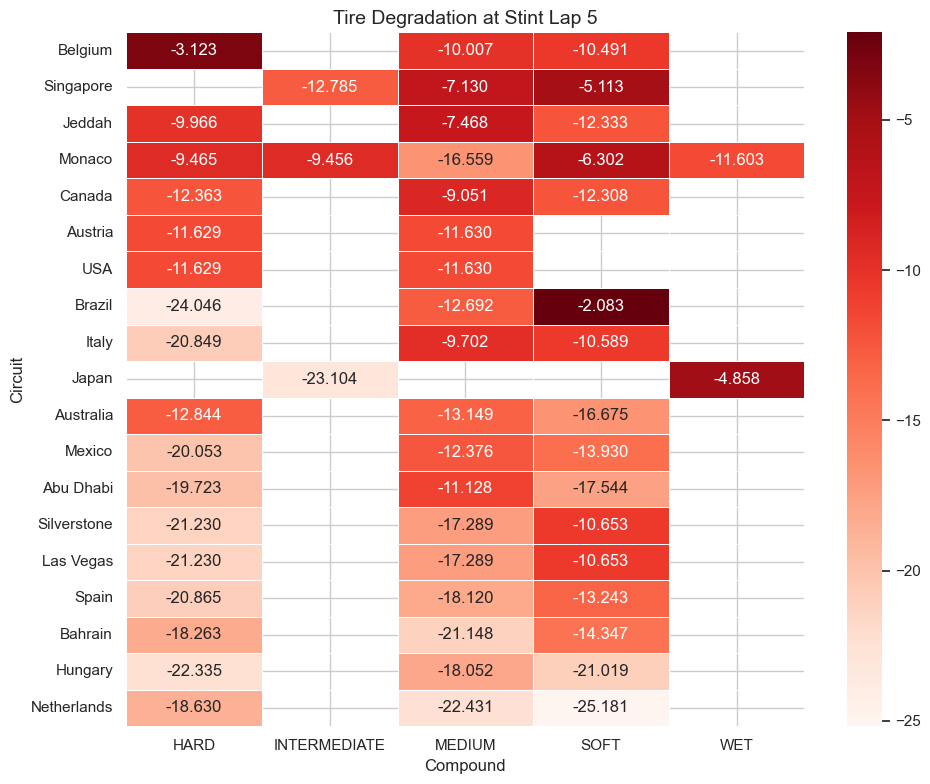

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, annot=True, cmap='Reds', fmt=".3f", linewidths=0.5)

plt.title(f"Tire Degradation at Stint Lap {lap_cutoff}", fontsize=14)
plt.xlabel("Compound")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()


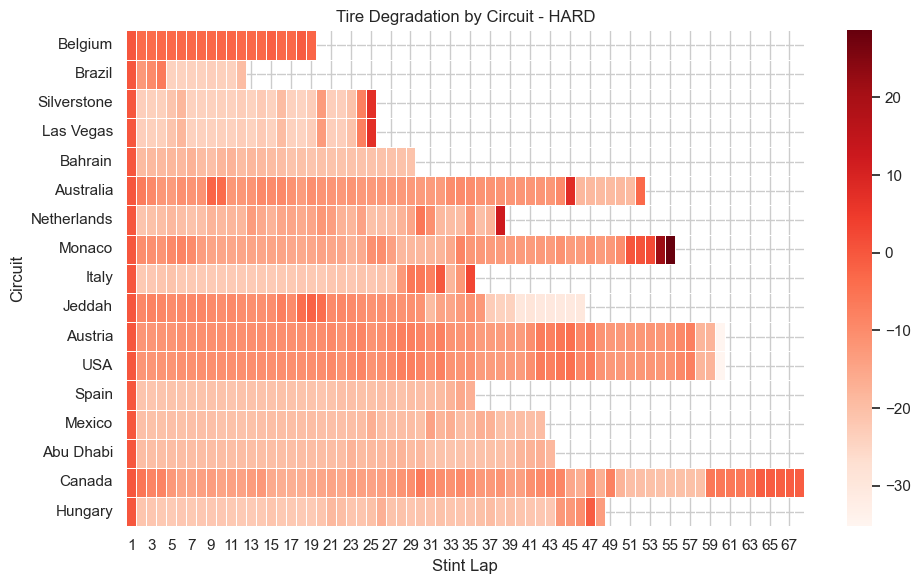

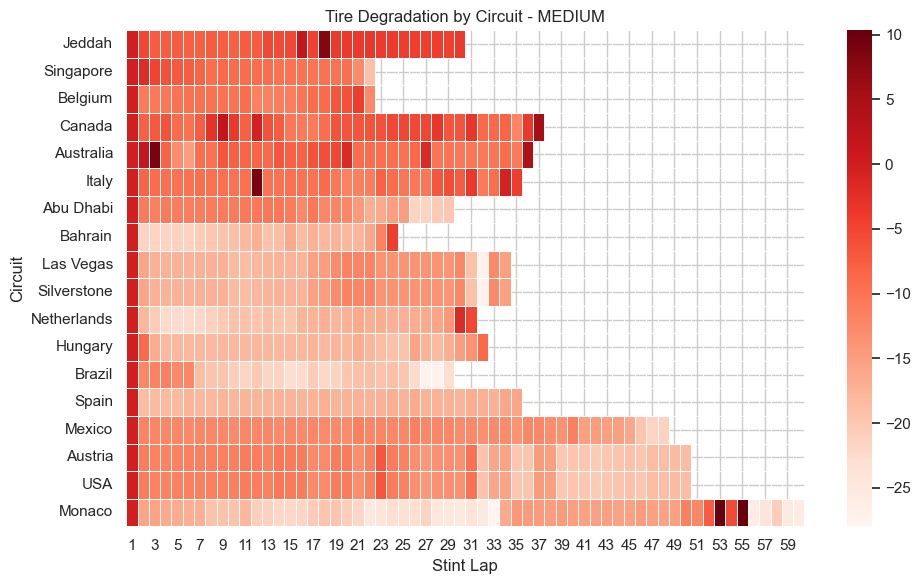

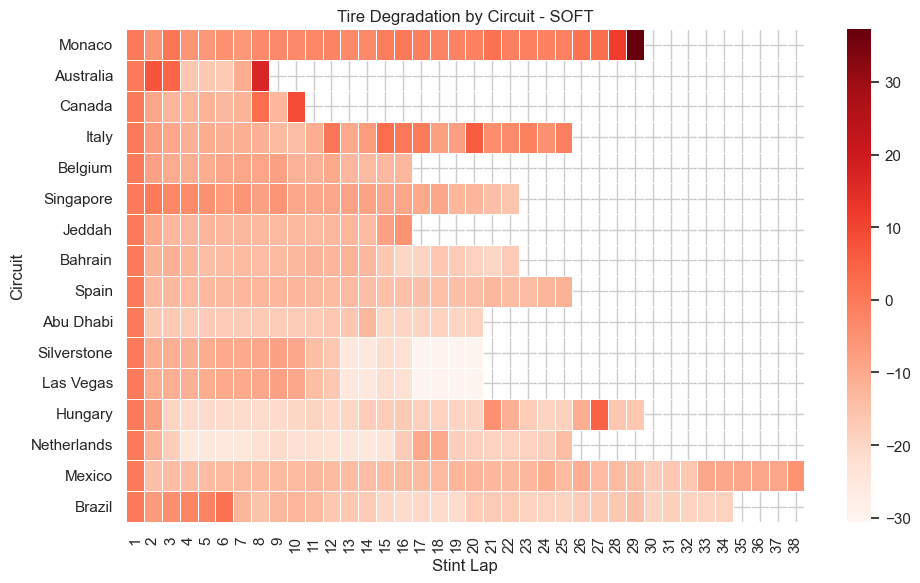

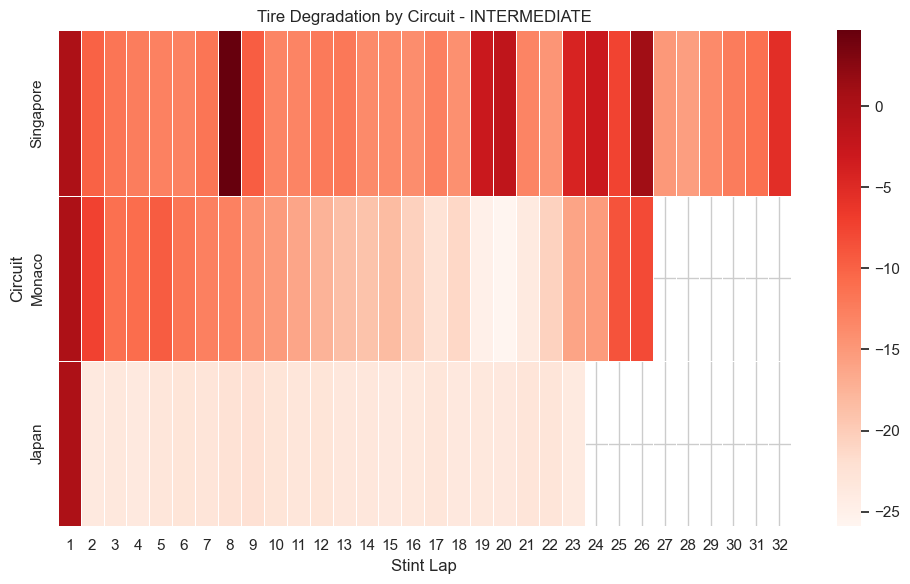

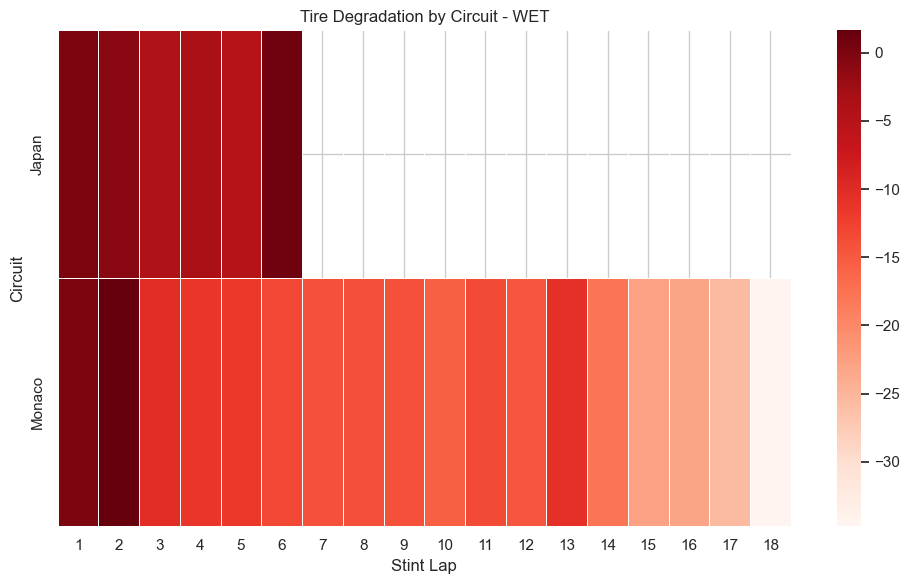

In [19]:

# Create a separate heatmap for each compound to visualize which circuits have the most aggressive tire wear
compounds = grouped['Compound'].unique()

for compound in compounds:
    # Filter data for the current compound
    compound_data = grouped[grouped['Compound'] == compound]
    # Pivot: rows = Circuit, columns = StintLap, values = AvgDeltaFromFirstLap
    pivot = compound_data.pivot(index='Circuit', columns='StintLap', values='AvgDeltaFromFirstLap')
    # Sort circuits by total degradation (sum across stint laps)
    pivot['TotalDegradation'] = pivot.sum(axis=1)
    pivot = pivot.sort_values(by='TotalDegradation', ascending=False).drop(columns='TotalDegradation')
    # Plot heatmap in its own figure
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=False, cmap='Reds', cbar=True, linewidths=0.5)
    plt.title(f"Tire Degradation by Circuit - {compound}")
    plt.xlabel("Stint Lap")
    plt.ylabel("Circuit")
    plt.tight_layout()
    plt.show()



In [20]:
# Group by Compound and StintLap to get average delta at each lap
compound_degradation = df.groupby(['Compound', 'StintLap'])['DeltaFromFirstLap'].mean().reset_index()

# Calculate average degradation rate per compound (delta increase per lap)
avg_rate = compound_degradation.groupby('Compound')['DeltaFromFirstLap'].apply(
    lambda x: (x.max() - x.min()) / (x.index.max() + 1)
).reset_index(name='AvgDegradationRate')

# Sort from fastest degrading to slowest
fastest_to_slowest = avg_rate.sort_values(by='AvgDegradationRate', ascending=False)

print("💥 Compound degradation ranking (fastest to slowest):")
print(fastest_to_slowest)

💥 Compound degradation ranking (fastest to slowest):
       Compound  AvgDegradationRate
0          HARD            0.303794
2        MEDIUM            0.227691
1  INTERMEDIATE            0.204440
4           WET            0.160764
3          SOFT            0.090218


 Total tire degradation by circuit (higher = more aggressive tire wear):
Circuit
Belgium       -148.828483
Singapore     -294.482306
Italy         -388.607129
Japan         -495.158798
Bahrain       -498.296544
Silverstone   -538.107774
Las Vegas     -538.107774
Australia     -563.134725
Brazil        -569.874898
Spain         -584.808248
Jeddah        -602.858768
Netherlands   -633.395302
Mexico        -683.594054
USA           -701.043169
Austria       -701.043169
Abu Dhabi     -740.800193
Canada        -763.677489
Hungary       -843.436309
Monaco        -854.308576
Name: DeltaFromFirstLap, dtype: float64


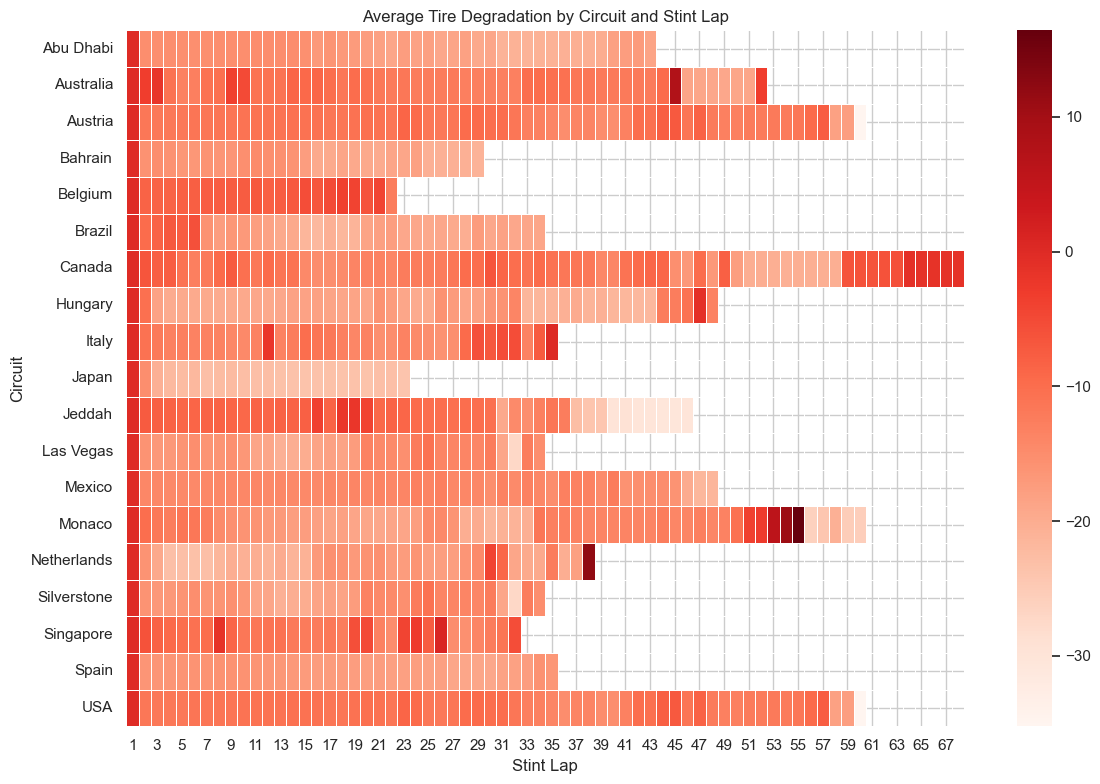

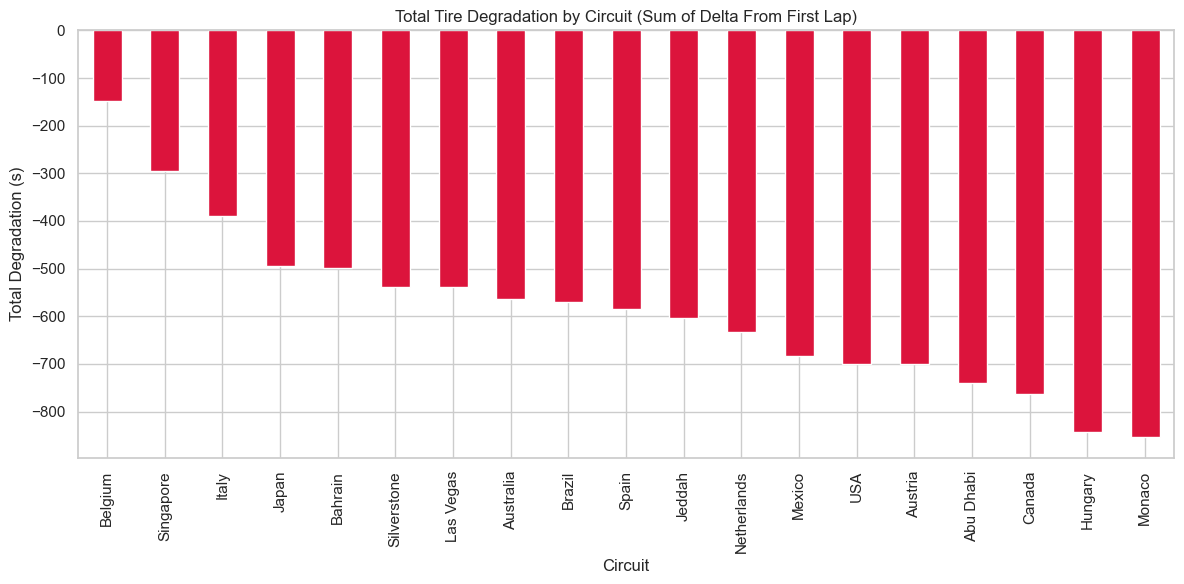

In [21]:
# Calculate average degradation per circuit (across all compounds and stints)
circuit_degradation = df.groupby(['Circuit', 'StintLap'])['DeltaFromFirstLap'].mean().reset_index()

# For each circuit, compute the total degradation over a typical stint (sum of deltas)
total_degradation_by_circuit = circuit_degradation.groupby('Circuit')['DeltaFromFirstLap'].sum().sort_values(ascending=False)

print(" Total tire degradation by circuit (higher = more aggressive tire wear):")
print(total_degradation_by_circuit)

# Visualize: Heatmap of degradation by circuit and stint lap
pivot_circuit = circuit_degradation.pivot(index='Circuit', columns='StintLap', values='DeltaFromFirstLap')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_circuit, annot=False, cmap='Reds', cbar=True, linewidths=0.5)
plt.title("Average Tire Degradation by Circuit and Stint Lap")
plt.xlabel("Stint Lap")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()

# Bar plot: total degradation by circuit
plt.figure(figsize=(12, 6))
total_degradation_by_circuit.plot(kind='bar', color='crimson')
plt.title("Total Tire Degradation by Circuit (Sum of Delta From First Lap)")
plt.ylabel("Total Degradation (s)")
plt.xlabel("Circuit")
plt.tight_layout()
plt.show()


Circuits where Hard tire had the lowest total degradation (i.e., outperformed others):
Circuit
Abu Dhabi      HARD
Australia      HARD
Bahrain        HARD
Canada         HARD
Hungary        HARD
Italy          HARD
Jeddah         HARD
Mexico         HARD
Netherlands    HARD
Spain          HARD
dtype: object

Abu Dhabi:
  Hard total degradation: -820.45 s
  Next best (MEDIUM): -371.04 s
  Hard was better by 449.42 s over a stint

Australia:
  Hard total degradation: -586.83 s
  Next best (MEDIUM): -259.85 s
  Hard was better by 326.98 s over a stint

Bahrain:
  Hard total degradation: -550.95 s
  Next best (MEDIUM): -413.39 s
  Hard was better by 137.56 s over a stint

Canada:
  Hard total degradation: -823.89 s
  Next best (MEDIUM): -222.80 s
  Hard was better by 601.09 s over a stint

Hungary:
  Hard total degradation: -945.33 s
  Next best (MEDIUM): -525.52 s
  Hard was better by 419.82 s over a stint

Italy:
  Hard total degradation: -629.90 s
  Next best (MEDIUM): -283.56 s
  Hard 

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


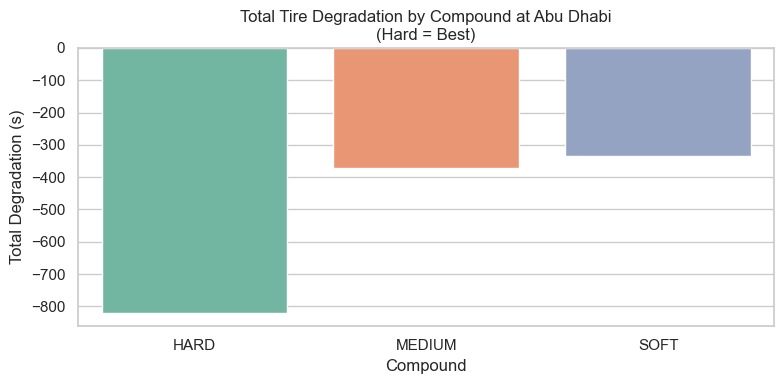

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


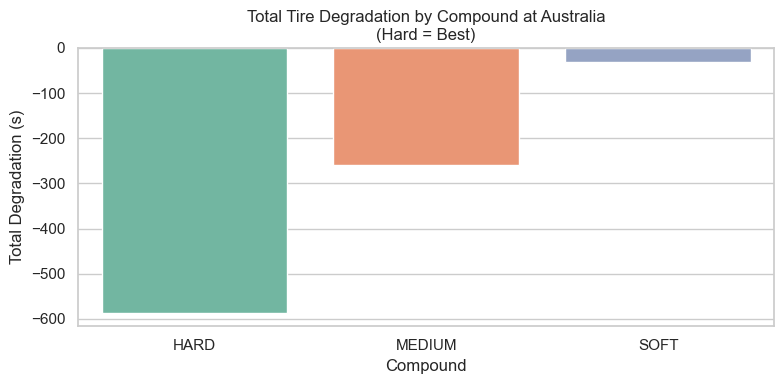

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


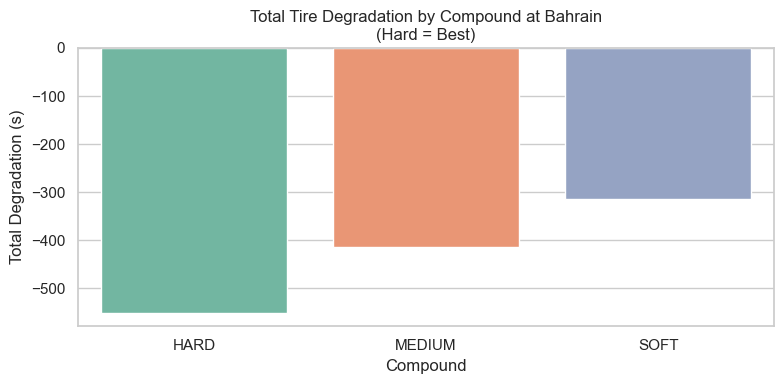

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


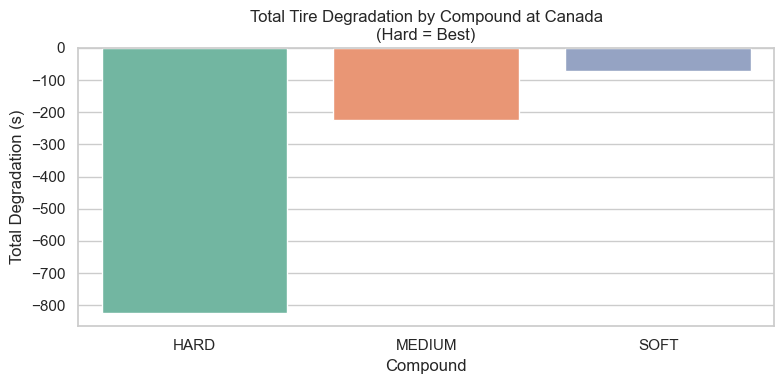

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


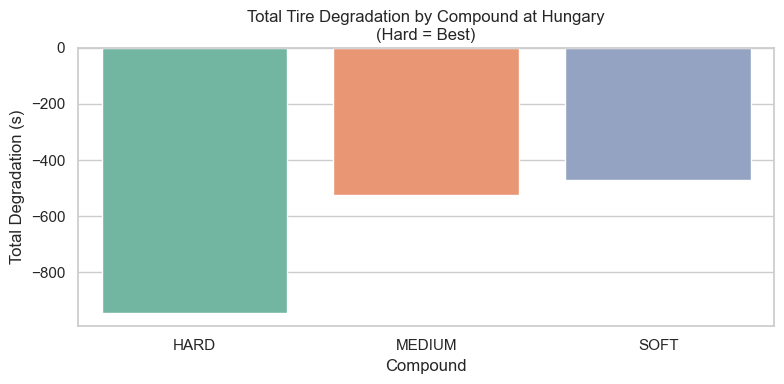

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


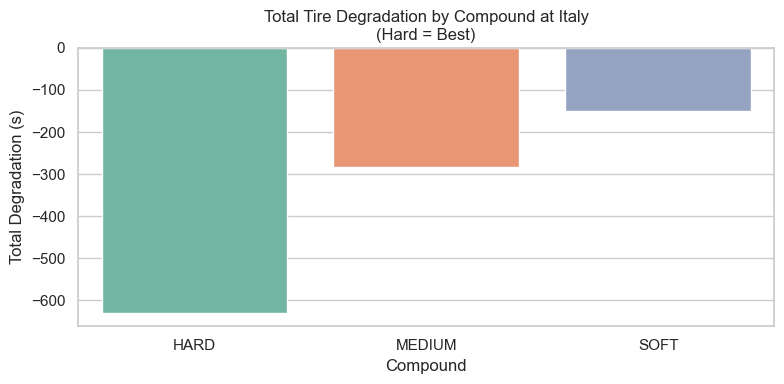

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


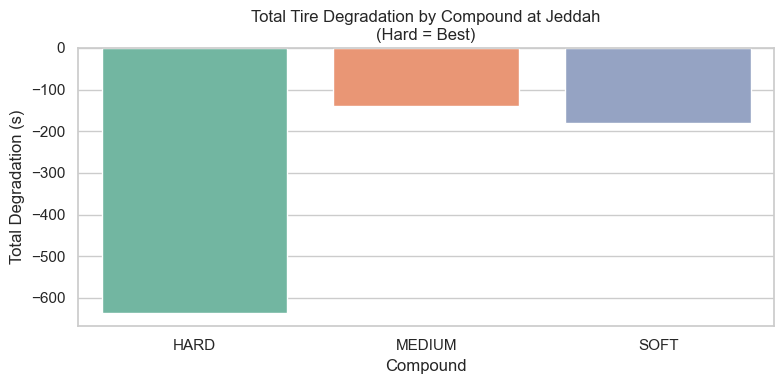

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


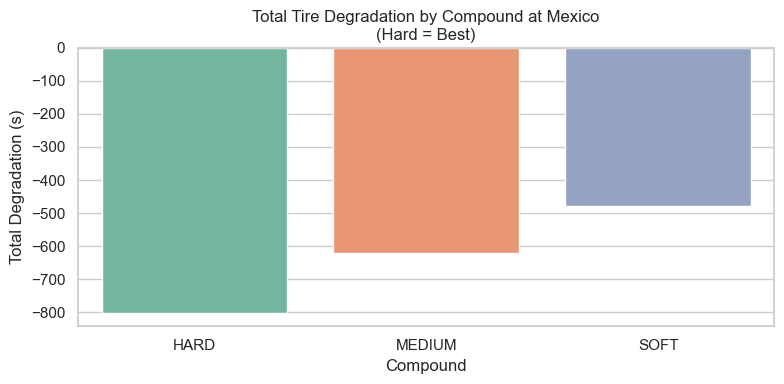

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


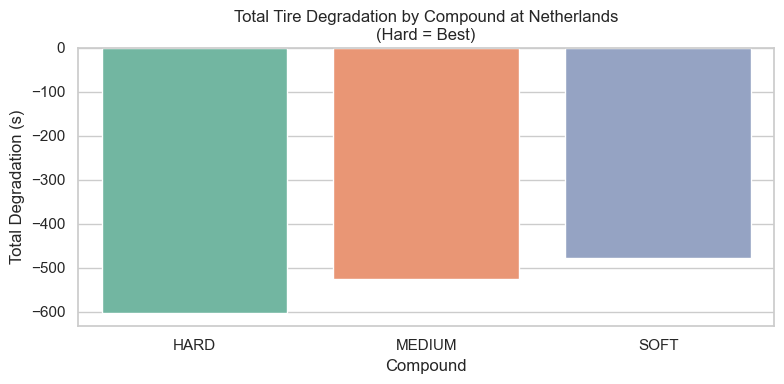

C:\Users\manpr\AppData\Local\Temp\ipykernel_9688\3258453649.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')


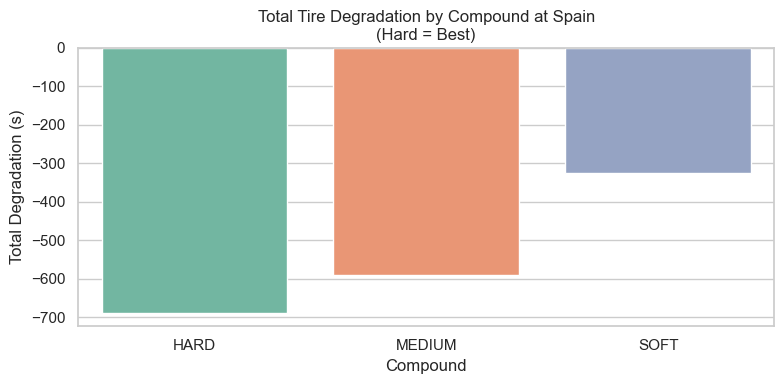

In [22]:

# Analyze: Are there circuits where hard tires outperform others significantly?

# 1. Calculate average degradation per compound per circuit
compound_circuit_degradation = df.groupby(['Circuit', 'Compound', 'StintLap'])['DeltaFromFirstLap'].mean().reset_index()

# 2. For each circuit and compound, compute total degradation over a typical stint (sum of deltas)
total_degradation_by_circuit_compound = compound_circuit_degradation.groupby(['Circuit', 'Compound'])['DeltaFromFirstLap'].sum().reset_index()

# 3. Pivot for easier comparison: rows = Circuit, columns = Compound, values = total degradation
pivot_degradation = total_degradation_by_circuit_compound.pivot(index='Circuit', columns='Compound', values='DeltaFromFirstLap')

# 4. For each circuit, find which compound had the lowest (best) total degradation
best_compound_per_circuit = pivot_degradation.idxmin(axis=1)
hard_best_circuits = best_compound_per_circuit[best_compound_per_circuit.str.lower().str.contains('hard')]

print("Circuits where Hard tire had the lowest total degradation (i.e., outperformed others):")
print(hard_best_circuits)

# 5. Quantify how much better Hard was compared to the next best compound at those circuits
for circuit in hard_best_circuits.index:
    degradation_row = pivot_degradation.loc[circuit]
    sorted_degradation = degradation_row.sort_values()
    hard_degradation = degradation_row[hard_best_circuits[circuit]]
    next_best_compound = sorted_degradation.index[1]
    next_best_degradation = sorted_degradation.iloc[1]
    diff = next_best_degradation - hard_degradation
    print(f"\n{circuit}:")
    print(f"  Hard total degradation: {hard_degradation:.2f} s")
    print(f"  Next best ({next_best_compound}): {next_best_degradation:.2f} s")
    print(f"  Hard was better by {diff:.2f} s over a stint")

# 6. Visualize: Barplot of total degradation by compound for circuits where Hard was best
import matplotlib.pyplot as plt
import seaborn as sns

for circuit in hard_best_circuits.index:
    plt.figure(figsize=(8, 4))
    degradation_row = pivot_degradation.loc[circuit]
    degradation_row = degradation_row.dropna()
    sns.barplot(x=degradation_row.index, y=degradation_row.values, palette='Set2')
    plt.title(f"Total Tire Degradation by Compound at {circuit}\n(Hard = Best)")
    plt.ylabel("Total Degradation (s)")
    plt.xlabel("Compound")
    plt.tight_layout()
    plt.show()



1. The final result from this analysis is a summary of which circuits had the lowest total tire degradation when using the Hard compound tire, compared to other compounds.
2. Specifically, it identifies the circuits where the Hard tire outperformed the others, quantifies by how much (in seconds) it was better than the next best compound,  visualizes the total degradation for each compound at those circuits using bar plots.
3. The printed output lists the circuits, the degradation values for Hard and the next best compound, and the difference.
4. The bar plots provide a visual comparison of total degradation by compound for each relevant circuit.
